## Lecture: The (Py)Tesseract Library

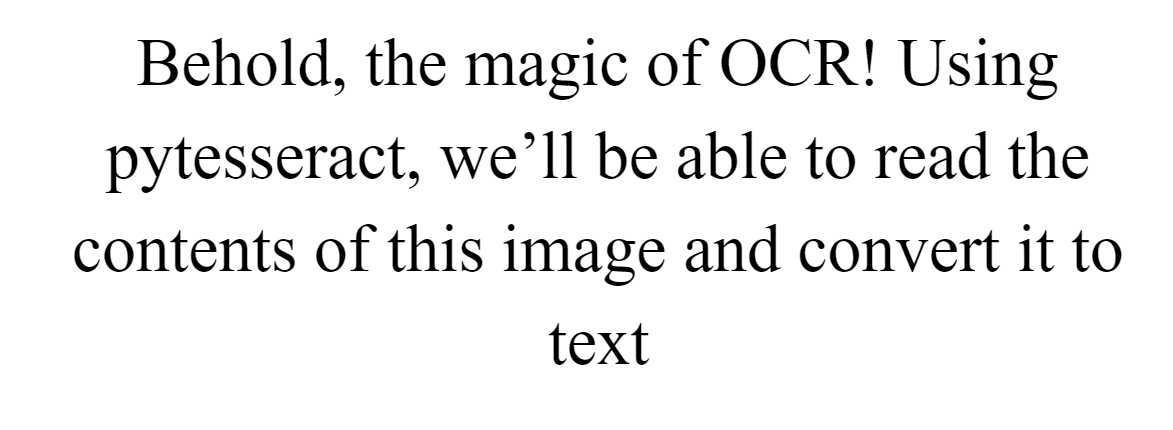

In [1]:
# We're going to start experimenting with tesseract using just a simple image of nice clean text.
# Lets first import Image from PIL and display the image text.png.
from PIL import Image

image = Image.open("readonly/text.png")
display(image)

In [2]:
# Great, we have a base image of some big clear text
# Lets import pytesseract and use the dir() fundtion to get a sense of what might be some interesting
# functions to play with
import pytesseract
dir(pytesseract)
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract'

In [3]:
# It looks like there are just a handful of interesting functions, and I think image_to_string
# is probably our best bet. Lets use the help() function to interrogate this a bit more 
help(pytesseract.image_to_string)

Help on function image_to_string in module pytesseract.pytesseract:

image_to_string(image, lang=None, config='', nice=0, output_type='string', timeout=0)
    Returns the result of a Tesseract OCR run on the provided image to string



In [4]:
# So this function takes an image as the first parameter, then there are a bunch of optional parameters,
# and it will return the results of the OCR. I think it's worth comparing this documentation string
# with the documentation we were receiving from the PILLOW module. Lets run the help command on the 
# Image resize function()
help(Image.Image.resize)

Help on function resize in module PIL.Image:

resize(self, size, resample=None, box=None, reducing_gap=None)
    Returns a resized copy of this image.

    :param size: The requested size in pixels, as a 2-tuple:
       (width, height).
    :param resample: An optional resampling filter.  This can be
       one of :py:data:`Resampling.NEAREST`, :py:data:`Resampling.BOX`,
       :py:data:`Resampling.BILINEAR`, :py:data:`Resampling.HAMMING`,
       :py:data:`Resampling.BICUBIC` or :py:data:`Resampling.LANCZOS`.
       If the image has mode "1" or "P", it is always set to
       :py:data:`Resampling.NEAREST`. If the image mode specifies a number
       of bits, such as "I;16", then the default filter is
       :py:data:`Resampling.NEAREST`. Otherwise, the default filter is
       :py:data:`Resampling.BICUBIC`. See: :ref:`concept-filters`.
    :param box: An optional 4-tuple of floats providing
       the source image region to be scaled.
       The values must be within (0, 0, width, heig

In [5]:
# Notice how the PILLOW function has a bit more information in it. First it's using a specific format
# called reStructuredText, which is similar in intent to document markups such as HTML, the language of
# the web. The intent is to embed semantics in the documentation itself. For instance, in the resize()
# function we see the words "param size" with colons surrounding it. This allows documentation engines
# which create web docs from source code to link the parameter to the extended docs about that parameter.
# In this case the extended docs tell us that the size should be passed as a tuple of width and height.
# Notice how the docs for image_to_string, for instance, indicate that there is a "lang" parameter we can
# use, but then fail to say anything about what that parameter is for or what its format is.
#
# What this really means is that we need to dig deeper. Here's a quick hack if you want to look at the
# source code of a function -- you can use the inspect getsource() command and print the results
import inspect
src = inspect.getsource(pytesseract.image_to_string)
print(src)

def image_to_string(
    image,
    lang=None,
    config='',
    nice=0,
    output_type=Output.STRING,
    timeout=0,
):
    """
    Returns the result of a Tesseract OCR run on the provided image to string
    """
    args = [image, 'txt', lang, config, nice, timeout]

    return {
        Output.BYTES: lambda: run_and_get_output(*(args + [True])),
        Output.DICT: lambda: {'text': run_and_get_output(*args)},
        Output.STRING: lambda: run_and_get_output(*args),
    }[output_type]()



In [6]:
# There's actually another way in jupyter, and that's to append *two* question marks to the end of
# a given function or module. Other editors have similar features, and is a great reason to use a 
# software development environment
pytesseract.image_to_string??

Signature:
pytesseract.image_to_string(
    image,
    lang=None,
    config='',
    nice=0,
    output_type='string',
    timeout=0,
)
Source:   
def image_to_string(
    image,
    lang=None,
    config='',
    nice=0,
    output_type=Output.STRING,
    timeout=0,
):
    """
    Returns the result of a Tesseract OCR run on the provided image to string
    """
    args = [image, 'txt', lang, config, nice, timeout]

    return {
        Output.BYTES: lambda: run_and_get_output(*(args + [True])),
        Output.DICT: lambda: {'text': run_and_get_output(*args)},
        Output.STRING: lambda: run_and_get_output(*args),
    }[output_type]()
File:      c:\users\kp\appdata\local\programs\python\python312\lib\site-packages\pytesseract\pytesseract.py
Type:      function

In [7]:
# We can see from the source code that there really isn't much more information about what the parameters
# are for this image_to_string function. This is because underneath the pytesseract library is calling a C++
# library which does all of the hard work, and the author just passes through all of the calls to the 
# underlying tesseract executable. This is a common issue when working with python libraries, and it means
# we need to do some web sleuthing in order to understand how we can interact with tesseract.
#
# In a case like this I just googled "tesseract command line parameters" and the first hit was what I was
# looking for, here's the URL: https://tesseract-ocr.github.io/tessdoc/Command-Line-Usage
#
# This goes to a wiki page which describes how to call the tesseract executable, and as we read down we see
# that we can actually have tesseract use multiple languages in its detection, such as English and Hindi, by
# passing them in as "eng+hin". Very cool. 

In [7]:
# One last thing to mention - the image_to_string() function takes in an "image", but the docs don't
# really describe what this image is underneath. Is it a string to an image file? A PILLOW image?
# Something else?
#
# Again we have to sleuth (and/or experiment) to understand what we should do. If we look at the source
# code for the pytesseract library, we see that there is a function called run_and_get_output(). Here's
# a link to that function on the author's github account:
# https://github.com/madmaze/pytesseract/blob/d1596f7f59a517ad814b7d810ccdef7d33763221/src/pytesseract.py#L199
#
# In this function we see that one of the first things which happens is the image is saved through
# the save_image() function. Here's that line of code:
# https://github.com/madmaze/pytesseract/blob/d1596f7f59a517ad814b7d810ccdef7d33763221/src/pytesseract.py#L116
#
# And we see there that another function is called, prepare(image), which actually loads the image as a
# PILLOW image file. So yes, sending a PIL image file is appropriate use for this function! It sure would
# have been useful for the author to have included this information in reStructuredText to help us not have
# to dig through the implementation. But, this is an open source project -- maybe you would like to contribute
# back better documentation?
#
# Hint: The doc line we needed was :param image: A PIL Image.Image file or an ndarray of bytes
#
# In the end, we often don't do this full level of investigation, and we just experiment and try things. It
# seems likely that a PIL Image.Image would work, given how well known PIL is in the python world. But still,
# as you explore and use different libraries you'll see a breadth of different documentation norms, so it's
# useful to know how to explore the source code. And now that you're at the end of this course, you've got
# the skills to do so!
#
# Ok, lets try and run tesseract on this image
text = pytesseract.image_to_string(image)
print(text)

Behold, the magic of OCR! Using
pytesseract, we’ll be able to read the
contents of this image and convert it to
text



In [9]:
# Looks great! We see that the output includes new line characters, and faithfully represents the text
# but doesn't include any special formatting. Lets go on and look at something with a bit more nuance to it.

## More Tesseract

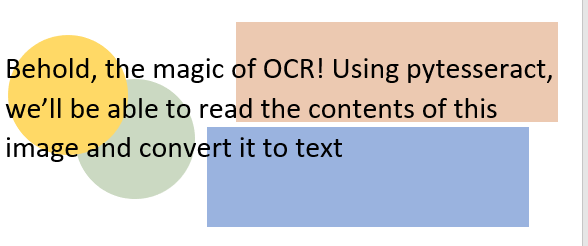

In [8]:
# In the previous example, we were using a clear, unambiguous image for conversion. Sometimes there will 
# be noise in images you want to OCR, making it difficult to extract the text. Luckily, there are 
# techniques we can use to increase the efficacy of OCR with pytesseract and Pillow.
#
# Let's use a different image this time, with the same text as before but with added noise in the picture. 
# We can view this image using the following code. 
from PIL import Image
img = Image.open("readonly/Noisy_OCR.PNG")
display(img)

In [9]:
# As you can see, this image had shapes of different opacities behind the text, which can confuse  
# the tesseract engine. Let's see if OCR will work on this noisy image
import pytesseract
text = pytesseract.image_to_string(Image.open("readonly/Noisy_OCR.PNG"))
print(text)

e magic of OCR! Using pytesseract,
le to read the contents of this

d convert it to text



In [12]:
# This is a bit surprising given how nicely tesseract worked previously! Let's experiment on the image 
# using techniqes that will allow for more effective image analysis. First up, lets change the size of
# the image

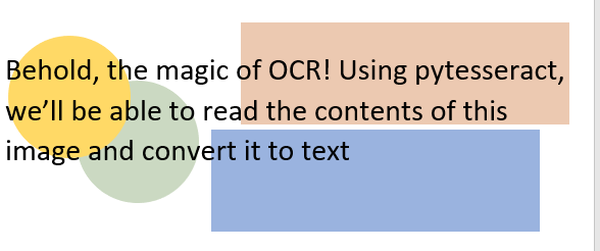

e magic of OCR! Using pytesseract,
le to read the contents of this
d convert it to text




In [11]:
# First we will import PIL
import PIL 
# Then set the base width of our image
basewidth = 600 
# Now lets open it
img = Image.open("readonly/Noisy_OCR.PNG")
# We want to get the correct aspect ratio, so we can do this by taking the base width and dividing
# it by the actual width of the image
wpercent = (basewidth / float(img.size[0]))
# With that ratio we can just get the appropriate height of the image.
hsize = int((float(img.size[1]) * float(wpercent)))
# Finally, lets resize the image. antialiasing is a specific way of resizing lines to try and make them 
# appear smooth
img = img.resize((basewidth, hsize), PIL.Image.LANCZOS)
# Now lets save this to a file
img.save('resized_nois.png') # save the image as a jpg
# And finally, lets display it
display(img)
# and run OCR
text = pytesseract.image_to_string(Image.open('resized_nois.png')) 
print(text)

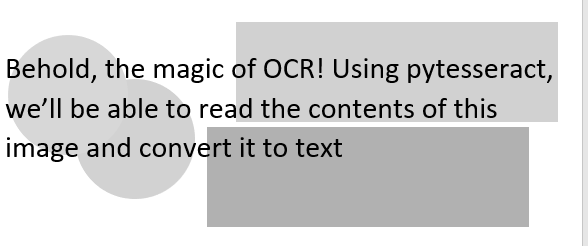

Behold, the magic of OCR! Using pytesseract,
we'll be able to read the contents of this
image and convert it to text



In [12]:
# hrm, no improvement for resizing the image. Let's convert the image to greyscale. Converting images 
# can be done in many different ways. If we poke around in the PILLOW documentation we find that one of
# the easiest ways to do this is to use the convert() function and pass in the string 'L'
img = Image.open('readonly/Noisy_OCR.PNG')
img = img.convert('L')
# Now lets save that image
img.save('greyscale_noise.jpg')
# And run OCR on the greyscale image
text = pytesseract.image_to_string(Image.open('greyscale_noise.jpg')) 
display(img)
print(text)

In [15]:
# Wow, that worked really well! If we look at the help documentation using the help function
# as in help(img.convert) we see that the conversion mechanism is the ITU-R 601-2 luma transform.
# There's more information about this out there, but this method essentially takes a three channel image,
# where there is information for the amount of red, green, and blue (R, G, and B), and reduces it
# to a single channel to represent luminosity. This method actually comes from how standard
# definition television sets encoded color onto black and while images. If you get really interested
# in image manipulation and recognition, learning about color spaces and how we represent color, both
# computationally and through human perception, is really an interesting field.

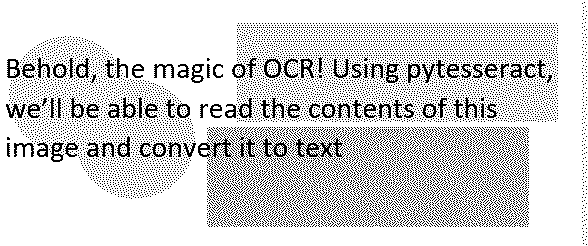

In [13]:
# Even though we have now the complete text of the image, there are a few other techniques
# we could use to help improve OCR detection in the event that the above two don't help.
# The next approach I would use is called binarization, which means to separate into two
# distinct parts - in this case, black and white. Binarization is enacted through a process 
# called thresholding. If a pixel value is greater than a threshold value, it will be converted
# to a black pixel; if it is lower than the threshold it will be converted to a white pixel. 
# This process eliminates noise in the OCR process allowing greater image recognition accuracy. 
# With Pillow, this process is straightforward.
# Lets open the noisy impage and convert it using binarization
img = Image.open('readonly/Noisy_OCR.PNG').convert('1')
# Now lets save and display that image
img.save('black_white_noise.jpg')
display(img)

Trying with threshold 0


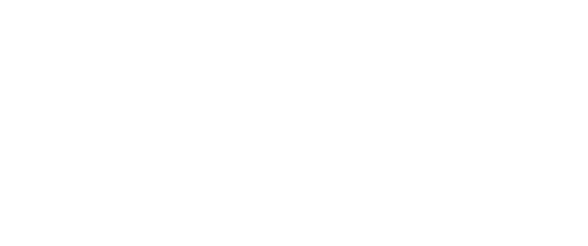


Trying with threshold 64


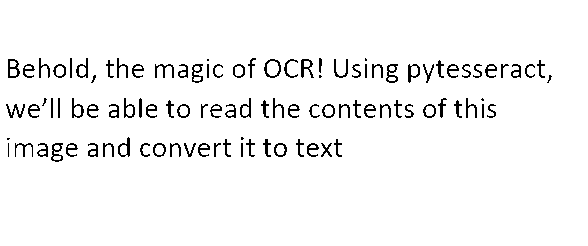

Behold, the magic of OCR! Using pytesseract,
we’ll be able to read the contents of this
image and convert it to text

Trying with threshold 128


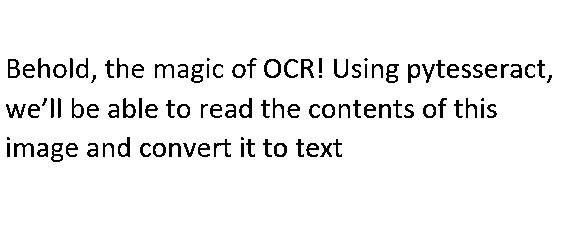

Behold, the magic of OCR! Using pytesseract,
we’ll be able to read the contents of this
image and convert it to text

Trying with threshold 192


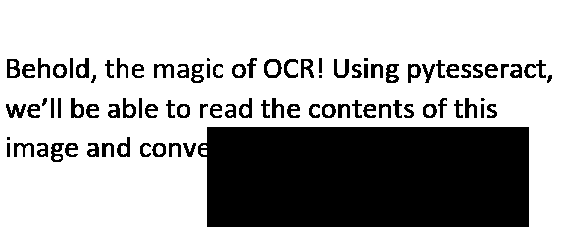

Behold, the magic of OCR! Using pytesseract,
we’ll be able to read the contents of this
image and conv


Trying with threshold 256


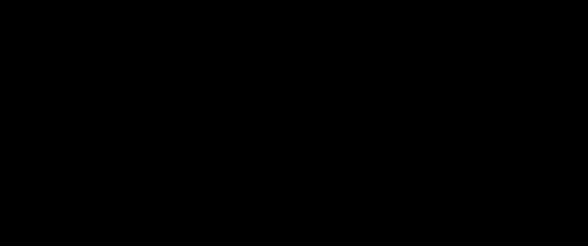

In [14]:
# So, that was a bit magical, and really required a fine reading of the docs to figure out
# that the number "1" is a string parameter to the convert function actually does the binarization.
# But you actually have all of the skills you need to write this functionality yourself.
# Lets walk through an example. First, lets define a function called binarize, which takes in
# an image and a threshold value:
def binarize(image_to_transform, threshold):
    # now, lets convert that image to a single greyscale image using convert()
    output_image=image_to_transform.convert("L")
    # the threshold value is usually provided as a number between 0 and 255.
    # the algorithm for the binarization is pretty simple, go through every pixel in the
    # image and, if it's greater than the threshold, turn it all the way up (255), and
    # if it's lower than the threshold, turn it all the way down (0).
    # so lets write this in code. First, we need to iterate over all of the pixels in the
    # image we want to work with
    for x in range(output_image.width):
        for y in range(output_image.height):
            # for the given pixel at w,h, lets check its value against the threshold
            if output_image.getpixel((x,y))< threshold: #note that the first parameter is actually a tuple object
                # lets set this to zero
                output_image.putpixel( (x,y), 0 )
            else:
                # otherwise lets set this to 255
                output_image.putpixel( (x,y), 255 )
    #now we just return the new image
    return output_image

# lets test this function over a range of different thresholds. Remember that you can use
# the range() function to generate a list of numbers at different step sizes. range() is called
# with a start, a stop, and a step size. So lets try range(0, 257, 64), which should generate 5
# images of different threshold values
for thresh in range(0,257,64):
    print("Trying with threshold " + str(thresh))
    # Lets display the binarized image inline
    display(binarize(Image.open('readonly/Noisy_OCR.PNG'), thresh))
    # And lets use tesseract on it. It's inefficient to binarize it twice but this is just for
    # a demo
    print(pytesseract.image_to_string(binarize(Image.open('readonly/Noisy_OCR.PNG'), thresh)))

In [18]:
# We can see from this that a threshold of 0 essentially turns everything white,
# that the text becomes more bold as we move towards a higher threshold, and that
# the shapes, which have a filled in grey color, become more evident at higher
# thresholds. In the next lecture we'll look a bit more at some of the challenges
# you can expect when doing OCR on real data

## Tesseract and Photographs

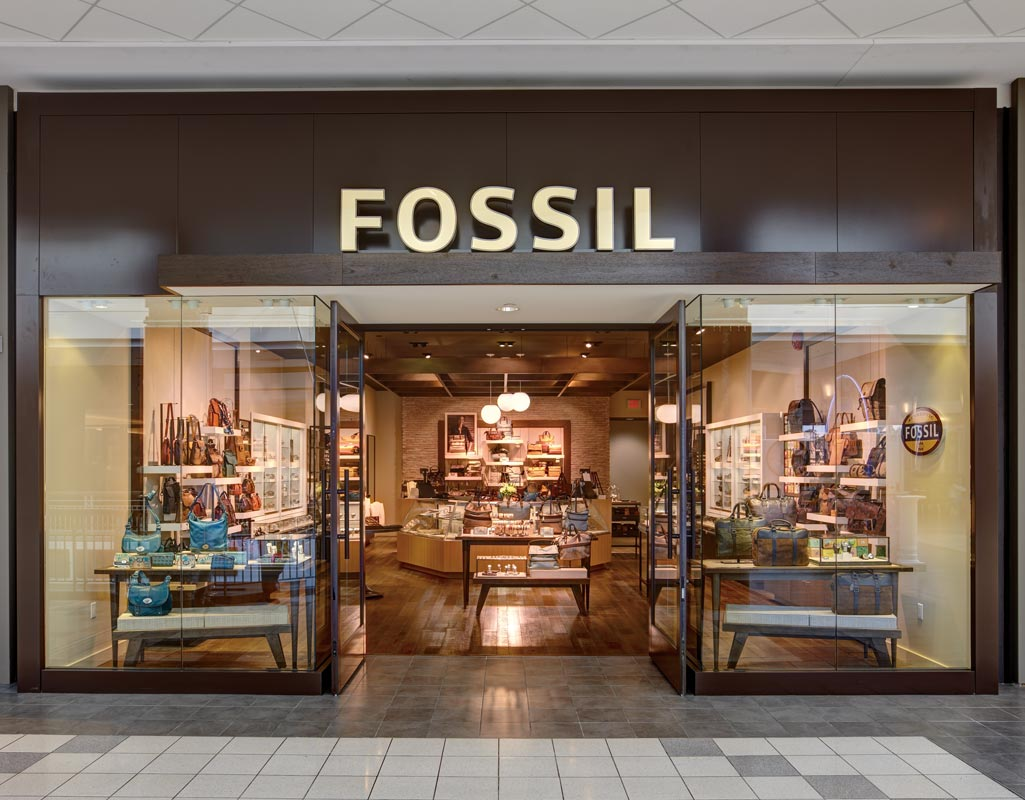

''

In [15]:
# Lets try a new example and bring together some of the things we have learned.
# Here's an image of a storefront, lets load it and try and get the name of the
# store out of the image
from PIL import Image
import pytesseract
# Lets read in the storefront image I've loaded into the course and display it
image=Image.open('readonly/storefront.jpg')
display(image)
# Finally, lets try and run tesseract on that image and see what the results are
pytesseract.image_to_string(image)

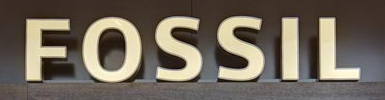

'FOSSIL\n'

In [16]:
# We see at the very bottom there is just an empty string. Tesseract is unable to take
# this image and pull out the name. But we learned how to crop the images in the
# last set of lectures, so lets try and help Tesseract by cropping out certain pieces.
#
# First, lets set the bounding box. In this image the store name is in a box
# bounded by (315, 170, 700, 270)
bounding_box=(315, 170, 700, 270)

# Now lets crop the image
title_image=image.crop(bounding_box)

# Now lets display it and pull out the text
display(title_image)
pytesseract.image_to_string(title_image)

In [17]:
# Great, we see how with a bit of a problem reduction we can make that work. So now we have
# been able to take an image, preprocess it where we expect to see text, and turn that text
# into a string that python can understand.
#
# If you look back up at the image though, you'll see there is a small sign inside of the
# shop that also has the shop name on it. I wonder if we're able to recognize the text on 
# that sign? Let's give it a try.
#
# First, we need to determine a bounding box for that sign. I'm going to show you a short-cut
# to make this easier in an optional video in this module, but for now lets just use the bounding
# box I decided on
bounding_box=(900, 420, 940, 445)

# Now, lets crop the image
little_sign=image.crop((900, 420, 940, 445))
display(little_sign)

In [18]:
# All right, that is a little sign! OCR works better with higher resolution images, so
# lets increase the size of this image by using the pillow resize() function
# Lets set the width and height equal to ten times the size it is now in a (w,h) tuple
new_size=(little_sign.width*10,little_sign.height*10)

# Now lets check the docs for resize()
help(little_sign.resize)

Help on method resize in module PIL.Image:

resize(size, resample=None, box=None, reducing_gap=None) method of PIL.Image.Image instance
    Returns a resized copy of this image.

    :param size: The requested size in pixels, as a 2-tuple:
       (width, height).
    :param resample: An optional resampling filter.  This can be
       one of :py:data:`Resampling.NEAREST`, :py:data:`Resampling.BOX`,
       :py:data:`Resampling.BILINEAR`, :py:data:`Resampling.HAMMING`,
       :py:data:`Resampling.BICUBIC` or :py:data:`Resampling.LANCZOS`.
       If the image has mode "1" or "P", it is always set to
       :py:data:`Resampling.NEAREST`. If the image mode specifies a number
       of bits, such as "I;16", then the default filter is
       :py:data:`Resampling.NEAREST`. Otherwise, the default filter is
       :py:data:`Resampling.BICUBIC`. See: :ref:`concept-filters`.
    :param box: An optional 4-tuple of floats providing
       the source image region to be scaled.
       The values must b

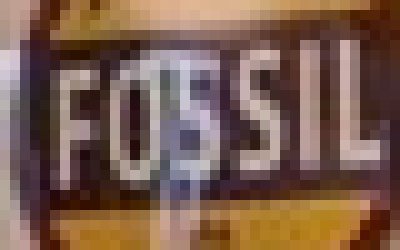

In [19]:
# We can see that there are a number of different filters for resizing the image. The
# default is Image.NEAREST. Lets see what that looks like
display(little_sign.resize( new_size, Image.NEAREST))

0


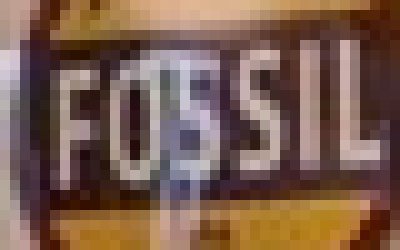

4


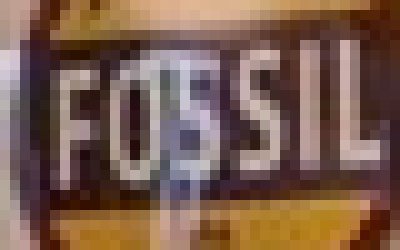

2


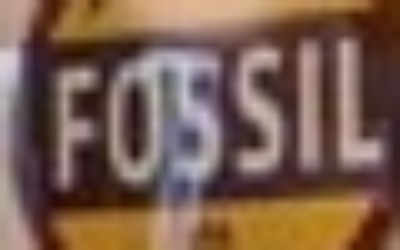

5


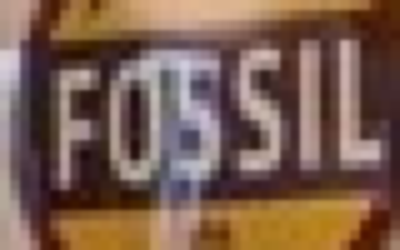

3


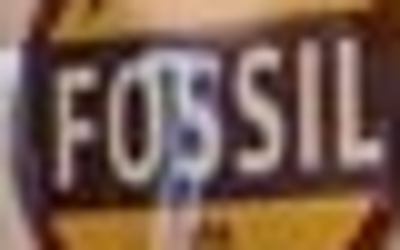

1


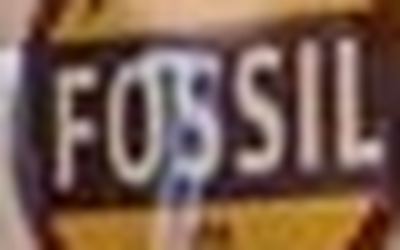

In [20]:
# I think we should be able to find something better. I can read it, but it looks
# really pixelated. Lets see what all the different resize options look like
options=[Image.NEAREST, Image.BOX, Image.BILINEAR, Image.HAMMING, Image.BICUBIC, Image.LANCZOS]
for option in options:
    # lets print the option name
    print(option)
    # lets display what this option looks like on our little sign
    display(little_sign.resize( new_size, option))

In [21]:
# From this we can notice two things. First, when we print out one of the resampling
# values it actually just prints an integer! This is really common: that the
# API developer writes a property, such as Image.BICUBIC, and then assigns it to an
# integer value to pass it around. Some languages use enumerations of values, which is
# common in say, Java, but in python this is a pretty normal way of doing things.
# The second thing we learned is that there are a number of different algorithms for
# image resampling. In this case, the Image.LANCZOS and Image.BICUBIC filters do a good
# job. Lets see if we are able to recognize the text off of this resized image

# First lets resize to the larger size
bigger_sign=little_sign.resize(new_size, Image.BICUBIC)
# Lets print out the text
pytesseract.image_to_string(bigger_sign)

''

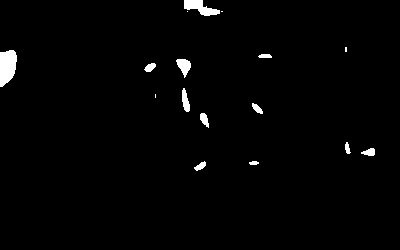

'Lae\n'

In [22]:
# Well, no text there. Lets try and binarize this. First, let me just bring in the
# binarization code we did earlier
def binarize(image_to_transform, threshold):
    output_image=image_to_transform.convert("L")
    for x in range(output_image.width):
        for y in range(output_image.height):
            if output_image.getpixel((x,y))< threshold:
                output_image.putpixel( (x,y), 0 )
            else:
                output_image.putpixel( (x,y), 255 )
    return output_image

# Now, lets apply binarizations with, say, a threshold of 190, and try and display that
# as well as do the OCR work
binarized_bigger_sign=binarize(bigger_sign, 190)
display(binarized_bigger_sign)
pytesseract.image_to_string(binarized_bigger_sign)

In [23]:
# Ok, that text is pretty useless. How should we pick the best binarization
# to use? Well, there are some methods, but lets just try something very simple to
# show how well this can work. We have an english word we are trying to detect, "FOSSIL".
# If we tried all binarizations, from 0 through 255, and looked to see if there were
# any english words in that list, this might be one way. So lets see if we can
# write a routine to do this.
#
# First, lets load a list of english words into a list. I put a copy in the readonly
# directory for you to work with
eng_dict=[]
with open ("readonly/words_alpha.txt", "r") as f:
    data=f.read()
    # now we want to split this into a list based on the new line characters
    eng_dict=data.split("\n")

# Now lets iterate through all possible thresholds and look for an english word, printing
# it out if it exists
for i in range(150,170):
    # lets binarize and convert this to s tring values
    strng=pytesseract.image_to_string(binarize(bigger_sign,i))
    # We want to remove non alphabetical characters, like ([%$]) from the text, here's
    # a short method to do that
    # first, lets convert our string to lower case only
    strng=strng.lower()
    # then lets import the string package - it has a nice list of lower case letters
    import string
    # now lets iterate over our string looking at it character by character, putting it in
    # the comaprison text
    comparison=''
    for character in strng:
        if character in string.ascii_lowercase:
            comparison=comparison+character
    # finally, lets search for comparison in the dictionary file
    if comparison in eng_dict:
        # and print it if we find it
        print(comparison)

In [28]:
# Well, not perfect, but we see fossil there among other values which are in the dictionary.
# This is not a bad way to clean up OCR data. It can useful to use a language or domain specific 
# dictionary in practice, especially if you are generating a search engine for specialized language
# such as a medical knowledge base or locations. And if you scroll up and look at the data
# we were working with - this small little wall hanging on the inside of the store - it's not
# so bad.
#
# At this point you've now learned how to manipulate images and convert them into text. In the
# next module in this course we're going to dig deeper further into a computer vision library
# which allows us to detect faces among other things. Then, on to the culminating project!

## Jupyter Widgets (Optional)

In [24]:
# In this brief lecture I want to introduce you to one of the more advanced features of the 
# Jupyter notebook development environment called widgets. Sometimes you want
# to interact with a function you have created and call it multiple times with different
# parameters. For instance, if we wanted to draw a red box around a portion of an
# image to try and fine tune the crop location. Widgets are one way to do this quickly
# in the browser without having to learn how to write a large desktop application.
#
# Lets check it out. First we want to import the Image and ImageDraw classes from the
# PILLOW package
from PIL import Image, ImageDraw

# Then we want to import the interact class from the widgets package
from ipywidgets import interact

# We will use interact to annotate a function. Lets bring in an image that we know we 
# are interested in, like the storefront image from a previous lecture
image=Image.open('readonly/storefront.jpg')

# Ok, our setup is done. Now we're going to use the interact decorator to indicate
# that we want to wrap the python function. We do this using the @ sign. This will
# take a set of parameters which are identical to the function to be called. Then Jupyter
# will draw some sliders on the screen to let us manipulate these values. Decorators,
# which is what the @ sign is describing, are standard python statements and just a
# short hand for functions which wrap other functions. They are a bit advanced though, so
# we haven't talked about them in this course, and you might just have to have some faith
@interact(left=100, top=100, right=200, bottom=200)

# Now we just write the function we had before
def draw_border(left, top, right, bottom):
    img=image.copy()
    drawing_object=ImageDraw.Draw(img)
    drawing_object.rectangle((left,top,right,bottom), fill = None, outline ='red')
    display(img)

interactive(children=(IntSlider(value=100, description='left', max=300, min=-100), IntSlider(value=100, descri…

In [30]:
# Jupyter widgets is certainly advanced territory, but if you would like
# to explore more you can read about what is available here: 
# https://ipywidgets.readthedocs.io/en/stable/examples/Using%20Interact.html